# Baseline QML Option Pricing (Quandela Challenge_Swaptions)

This notebook provides a clean baseline for the hackathon task:
- Load and inspect the Hugging Face dataset.
- Build a robust preprocessing pipeline.
- Train a hybrid QML model (MerLin quantum layer + classical head).
- Evaluate and generate predictions for the test split.


## 0) Environment

Install missing packages only if needed.


In [ ]:
# Optional install cell (uncomment if your environment is missing packages)
# %pip install -U merlinquantum datasets scikit-learn pandas matplotlib


## 1) Imports and Reproducibility


In [4]:
import random
import warnings
from dataclasses import dataclass

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from merlin import LexGrouping, QuantumLayer
from merlin.builder import CircuitBuilder

warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


## 2) Load Dataset


In [5]:
DATASET_ID = "Quandela/Challenge_Swaptions"

ds = load_dataset(DATASET_ID)
print(ds)


DatasetDict({
    train: Dataset({
        features: ['Date', 'Tenor : 1; Maturity : 0.0833333333333333', 'Tenor : 2; Maturity : 0.0833333333333333', 'Tenor : 3; Maturity : 0.0833333333333333', 'Tenor : 4; Maturity : 0.0833333333333333', 'Tenor : 5; Maturity : 0.0833333333333333', 'Tenor : 6; Maturity : 0.0833333333333333', 'Tenor : 7; Maturity : 0.0833333333333333', 'Tenor : 8; Maturity : 0.0833333333333333', 'Tenor : 9; Maturity : 0.0833333333333333', 'Tenor : 10; Maturity : 0.0833333333333333', 'Tenor : 15; Maturity : 0.0833333333333333', 'Tenor : 20; Maturity : 0.0833333333333333', 'Tenor : 25; Maturity : 0.0833333333333333', 'Tenor : 30; Maturity : 0.0833333333333333', 'Tenor : 1; Maturity : 0.25', 'Tenor : 2; Maturity : 0.25', 'Tenor : 3; Maturity : 0.25', 'Tenor : 4; Maturity : 0.25', 'Tenor : 5; Maturity : 0.25', 'Tenor : 6; Maturity : 0.25', 'Tenor : 7; Maturity : 0.25', 'Tenor : 8; Maturity : 0.25', 'Tenor : 9; Maturity : 0.25', 'Tenor : 10; Maturity : 0.25', 'Tenor : 15; Mat

## 3) Helper Functions (Split + Target Detection)


In [8]:
def pick_train_split(dataset_dict: DatasetDict):
    if "train" in dataset_dict:
        return "train"
    return list(dataset_dict.keys())[0]


def pick_test_split(dataset_dict: DatasetDict):
    for name in ["test", "public_test", "validation"]:
        if name in dataset_dict:
            return name
    return None


def infer_target_columns(df: pd.DataFrame):
    explicit_pairs = [
        ("call_price", "put_price"),
        ("call", "put"),
        ("price_call", "price_put"),
        ("call_option_price", "put_option_price"),
        ("price_call_option", "price_put_option"),
    ]
    cols = set(df.columns)
    for c1, c2 in explicit_pairs:
        if c1 in cols and c2 in cols:
            return [c1, c2]

    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    call_like = [c for c in numeric_cols if "call" in c.lower()]
    put_like = [c for c in numeric_cols if "put" in c.lower()]

    if call_like and put_like:
        return [call_like[0], put_like[0]]

    # Conservative fallback: use last two numeric columns.
    # This keeps notebook runnable even when columns are named generically.
    if len(numeric_cols) >= 2:
        print("Warning: using fallback target inference (last two numeric columns).")
        print("Numeric columns:", numeric_cols)
        return numeric_cols[-2:]

    raise ValueError(
        "Could not infer call/put target columns automatically. "
        "Please set TARGET_COLS manually after inspecting columns."
    )


def dataset_to_df(split_ds: Dataset) -> pd.DataFrame:
    return split_ds.to_pandas()


## 4) Build Train/Validation/Test DataFrames

If the dataset only contains a training split, we create our own train/validation/test split.


In [9]:
train_split_name = pick_train_split(ds)
raw_train_df = dataset_to_df(ds[train_split_name]).copy()

print("Train split:", train_split_name)
print("Shape:", raw_train_df.shape)
print("Columns:", list(raw_train_df.columns))

# Manual override (set this explicitly if auto-detection is wrong)
# Example: TARGET_COLS = ["target_call", "target_put"]
TARGET_COLS = None

if TARGET_COLS is None:
    TARGET_COLS = infer_target_columns(raw_train_df)

print("Selected target columns:", TARGET_COLS)

missing = [c for c in TARGET_COLS if c not in raw_train_df.columns]
if missing:
    raise ValueError(f"Target columns not found: {missing}")

# 70/15/15 split from the train dataset.
train_df, temp_df = train_test_split(raw_train_df, test_size=0.30, random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train rows:", len(train_df), "| Val rows:", len(val_df), "| Test rows:", len(test_df))


Train split: train
Shape: (983, 225)
Columns: ['Date', 'Tenor : 1; Maturity : 0.0833333333333333', 'Tenor : 2; Maturity : 0.0833333333333333', 'Tenor : 3; Maturity : 0.0833333333333333', 'Tenor : 4; Maturity : 0.0833333333333333', 'Tenor : 5; Maturity : 0.0833333333333333', 'Tenor : 6; Maturity : 0.0833333333333333', 'Tenor : 7; Maturity : 0.0833333333333333', 'Tenor : 8; Maturity : 0.0833333333333333', 'Tenor : 9; Maturity : 0.0833333333333333', 'Tenor : 10; Maturity : 0.0833333333333333', 'Tenor : 15; Maturity : 0.0833333333333333', 'Tenor : 20; Maturity : 0.0833333333333333', 'Tenor : 25; Maturity : 0.0833333333333333', 'Tenor : 30; Maturity : 0.0833333333333333', 'Tenor : 1; Maturity : 0.25', 'Tenor : 2; Maturity : 0.25', 'Tenor : 3; Maturity : 0.25', 'Tenor : 4; Maturity : 0.25', 'Tenor : 5; Maturity : 0.25', 'Tenor : 6; Maturity : 0.25', 'Tenor : 7; Maturity : 0.25', 'Tenor : 8; Maturity : 0.25', 'Tenor : 9; Maturity : 0.25', 'Tenor : 10; Maturity : 0.25', 'Tenor : 15; Maturity :

## 5) Feature Preprocessing

- Numerical: median imputation + standard scaling
- Categorical: most frequent imputation + one-hot encoding


In [10]:
def build_preprocessor(X_df: pd.DataFrame):
    numeric_cols = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]
    categorical_cols = [c for c in X_df.columns if c not in numeric_cols]

    num_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    cat_pipe = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", ohe),
        ]
    )

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols),
        ],
        remainder="drop",
    )
    return pre, numeric_cols, categorical_cols


X_train_df = train_df.drop(columns=TARGET_COLS)
y_train = train_df[TARGET_COLS].astype(np.float32).to_numpy()

X_val_df = val_df.drop(columns=TARGET_COLS)
y_val = val_df[TARGET_COLS].astype(np.float32).to_numpy()

X_test_df = test_df.drop(columns=TARGET_COLS)
y_test = test_df[TARGET_COLS].astype(np.float32).to_numpy()

preprocessor, num_cols, cat_cols = build_preprocessor(X_train_df)
X_train_np = preprocessor.fit_transform(X_train_df)
X_val_np = preprocessor.transform(X_val_df)
X_test_np = preprocessor.transform(X_test_df)

if hasattr(X_train_np, "toarray"):
    X_train_np = X_train_np.toarray()
if hasattr(X_val_np, "toarray"):
    X_val_np = X_val_np.toarray()
if hasattr(X_test_np, "toarray"):
    X_test_np = X_test_np.toarray()

X_train_np = np.asarray(X_train_np, dtype=np.float32)
X_val_np = np.asarray(X_val_np, dtype=np.float32)
X_test_np = np.asarray(X_test_np, dtype=np.float32)

print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))
print("Processed feature dimension:", X_train_np.shape[1])


Numeric cols: 222 | Categorical cols: 1
Processed feature dimension: 672


## 6) Torch Tensors and Dataloaders


In [11]:
BATCH_SIZE = 64

X_train_t = torch.tensor(X_train_np, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val_np, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test_np, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = torch.utils.data.TensorDataset(X_train_t, y_train_t)
val_ds = torch.utils.data.TensorDataset(X_val_t, y_val_t)
test_ds = torch.utils.data.TensorDataset(X_test_t, y_test_t)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))


Train batches: 11 | Val batches: 3 | Test batches: 3


## 7) Hybrid QML Model (Classical Projection + Quantum Layer + Regression Head)

This avoids large input width in the quantum layer by projecting features down to a compact quantum input size.


In [12]:
@dataclass
class QMLConfig:
    n_quantum_inputs: int = 8
    n_modes: int = 10
    n_photons: int = 3
    grouped_features: int = 16
    hidden_dim: int = 64
    lr: float = 1e-3
    epochs: int = 25


config = QMLConfig()

# Respect simulation constraints in the challenge.
config.n_modes = min(max(config.n_modes, config.n_quantum_inputs + 1), 20)
config.n_photons = min(config.n_photons, 10)

print(config)


QMLConfig(n_quantum_inputs=8, n_modes=10, n_photons=3, grouped_features=16, hidden_dim=64, lr=0.001, epochs=25)


In [13]:
class HybridQMLRegressor(nn.Module):
    def __init__(self, input_dim: int, out_dim: int, cfg: QMLConfig):
        super().__init__()

        self.project = nn.Sequential(
            nn.Linear(input_dim, cfg.n_quantum_inputs),
            nn.Tanh(),
        )

        builder = CircuitBuilder(n_modes=cfg.n_modes)
        builder.add_entangling_layer(trainable=True, name="U1")
        builder.add_angle_encoding(modes=list(range(cfg.n_quantum_inputs)), name="x")
        builder.add_rotations(trainable=True, name="theta")
        builder.add_superpositions(depth=1)

        self.q_layer = QuantumLayer(
            input_size=cfg.n_quantum_inputs,
            builder=builder,
            n_photons=cfg.n_photons,
            dtype=torch.float32,
        )

        self.group = LexGrouping(self.q_layer.output_size, cfg.grouped_features)

        self.head = nn.Sequential(
            nn.Linear(cfg.grouped_features, cfg.hidden_dim),
            nn.ReLU(),
            nn.Linear(cfg.hidden_dim, out_dim),
        )

    def forward(self, x):
        z = self.project(x)
        q = self.q_layer(z)
        g = self.group(q)
        return self.head(g)


model = HybridQMLRegressor(
    input_dim=X_train_np.shape[1],
    out_dim=len(TARGET_COLS),
    cfg=config,
).to(DEVICE)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print("Trainable parameters:", trainable_params)


HybridQMLRegressor(
  (project): Sequential(
    (0): Linear(in_features=672, out_features=8, bias=True)
    (1): Tanh()
  )
  (q_layer): QuantumLayer(
    (_photon_loss_transform): PhotonLossTransform()
    (_detector_transform): DetectorTransform()
    (measurement_mapping): Probabilities()
  )
  (group): LexGrouping()
  (head): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)
Trainable parameters: 6702


## 8) Train and Evaluate


In [14]:
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0.0
    preds, targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            total_loss += loss.item() * xb.size(0)
            preds.append(yhat.cpu().numpy())
            targets.append(yb.cpu().numpy())

    preds = np.vstack(preds)
    targets = np.vstack(targets)
    avg_loss = total_loss / len(loader.dataset)
    rmse = mean_squared_error(targets, preds) ** 0.5
    mae = mean_absolute_error(targets, preds)
    return avg_loss, rmse, mae, preds, targets


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

history = []
best_val = float("inf")
best_state = None

for epoch in range(1, config.epochs + 1):
    model.train()
    running = 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        yhat = model(xb)
        loss = loss_fn(yhat, yb)
        loss.backward()
        optimizer.step()

        running += loss.item() * xb.size(0)

    train_loss = running / len(train_loader.dataset)
    val_loss, val_rmse, val_mae, _, _ = evaluate(model, val_loader, loss_fn)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    history.append((epoch, train_loss, val_loss, val_rmse, val_mae))
    print(
        f"Epoch {epoch:02d}/{config.epochs} | "
        f"train_loss={train_loss:.6f} | val_loss={val_loss:.6f} | "
        f"val_rmse={val_rmse:.6f} | val_mae={val_mae:.6f}"
    )

if best_state is not None:
    model.load_state_dict(best_state)

print("Best validation loss:", best_val)


Epoch 01/25 | train_loss=0.091457 | val_loss=0.056957 | val_rmse=0.238656 | val_mae=0.234775
Epoch 02/25 | train_loss=0.039011 | val_loss=0.018578 | val_rmse=0.136301 | val_mae=0.132051
Epoch 03/25 | train_loss=0.010061 | val_loss=0.002358 | val_rmse=0.048561 | val_mae=0.040610
Epoch 04/25 | train_loss=0.001187 | val_loss=0.001010 | val_rmse=0.031776 | val_mae=0.026975
Epoch 05/25 | train_loss=0.001181 | val_loss=0.001297 | val_rmse=0.036016 | val_mae=0.030239
Epoch 06/25 | train_loss=0.000916 | val_loss=0.000667 | val_rmse=0.025823 | val_mae=0.022166
Epoch 07/25 | train_loss=0.000562 | val_loss=0.000528 | val_rmse=0.022968 | val_mae=0.019241
Epoch 08/25 | train_loss=0.000542 | val_loss=0.000501 | val_rmse=0.022392 | val_mae=0.018756
Epoch 09/25 | train_loss=0.000503 | val_loss=0.000467 | val_rmse=0.021599 | val_mae=0.018247
Epoch 10/25 | train_loss=0.000463 | val_loss=0.000439 | val_rmse=0.020951 | val_mae=0.017703
Epoch 11/25 | train_loss=0.000431 | val_loss=0.000401 | val_rmse=0.020

## 9) Validation and Test Diagnostics


,epoch,train_loss,val_loss,val_rmse,val_mae
20,21,0.000206,0.000206,0.014345,0.011344
21,22,0.000193,0.000195,0.013957,0.011031
22,23,0.000184,0.000185,0.013595,0.010721
23,24,0.000173,0.000175,0.013233,0.010422
24,25,0.000166,0.000166,0.012884,0.010095


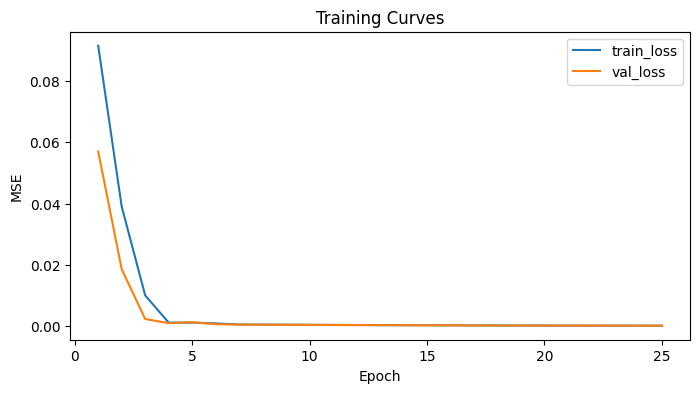

Holdout test: loss=0.000160 | rmse=0.012654 | mae=0.009617
Tenor : 25; Maturity : 30 | val_rmse=0.012989, val_mae=0.010500 | test_rmse=0.013053, test_mae=0.010110
Tenor : 30; Maturity : 30 | val_rmse=0.012779, val_mae=0.009690 | test_rmse=0.012243, test_mae=0.009124


In [15]:
import matplotlib.pyplot as plt

hist_df = pd.DataFrame(history, columns=["epoch", "train_loss", "val_loss", "val_rmse", "val_mae"])
display(hist_df.tail())

plt.figure(figsize=(8, 4))
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train_loss")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Curves")
plt.legend()
plt.show()

_, _, _, val_preds, val_targets = evaluate(model, val_loader, loss_fn)
test_loss, test_rmse, test_mae, test_preds, test_targets = evaluate(model, test_loader, loss_fn)

print(f"Holdout test: loss={test_loss:.6f} | rmse={test_rmse:.6f} | mae={test_mae:.6f}")

for i, target_name in enumerate(TARGET_COLS):
    rmse_val_i = mean_squared_error(val_targets[:, i], val_preds[:, i]) ** 0.5
    mae_val_i = mean_absolute_error(val_targets[:, i], val_preds[:, i])
    rmse_test_i = mean_squared_error(test_targets[:, i], test_preds[:, i]) ** 0.5
    mae_test_i = mean_absolute_error(test_targets[:, i], test_preds[:, i])
    print(
        f"{target_name} | "
        f"val_rmse={rmse_val_i:.6f}, val_mae={mae_val_i:.6f} | "
        f"test_rmse={rmse_test_i:.6f}, test_mae={mae_test_i:.6f}"
    )


## 10) Export Holdout Test Predictions

This exports predictions for the internal holdout test split to `notebooks/baseline_holdout_predictions.csv`.


In [17]:
model.eval()
with torch.no_grad():
    holdout_pred = model(X_test_t.to(DEVICE)).cpu().numpy()

id_candidates = [c for c in ["id", "ID", "row_id", "index"] if c in test_df.columns]
if id_candidates:
    out = pd.DataFrame({id_candidates[0]: test_df[id_candidates[0]].values})
else:
    out = pd.DataFrame({"id": np.arange(len(test_df))})

for i, col in enumerate(TARGET_COLS):
    out[f"pred_{col}"] = holdout_pred[:, i]
    out[f"true_{col}"] = y_test[:, i]

output_path = "baseline_holdout_predictions.csv"
out.to_csv(output_path, index=False)
print("Saved:", output_path)
display(out.head())


Saved: baseline_holdout_predictions.csv


,id,pred_Tenor : 25; Maturity : 30,true_Tenor : 25; Maturity : 30,pred_Tenor : 30; Maturity : 30,true_Tenor : 30; Maturity : 30
0,0,0.340711,0.344334,0.330527,0.332519
1,1,0.359338,0.374207,0.341158,0.356600
2,2,0.337534,0.339023,0.327345,0.327683
3,3,0.390145,0.395039,0.370026,0.369895
4,4,0.361217,0.338692,0.342927,0.324837


## 11) Next Steps for Improvement

- Set `TARGET_COLS` manually if auto-detection picks the wrong columns.
- Tune `n_modes`, `n_photons`, grouping size, and projection width.
- Try log-target transformation if price scales are wide.
- Add k-fold validation for more robust model selection.
- Compare against a classical baseline (MLP/XGBoost) to quantify QML lift.
